<a href="https://colab.research.google.com/github/rubyvanrooyen/HartRAO_OH-IR_stars/blob/master/HartRAO_OH_periodogram_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!git clone 'https://github.com/rubyvanrooyen/HartRAO_OH-IR_stars.git'
!ln -s HartRAO_OH-IR_stars/hart_io.py
!ln -s HartRAO_OH-IR_stars/periodogram.py

Cloning into 'HartRAO_OH-IR_stars'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 369 (delta 165), reused 344 (delta 150), pack-reused 0
Receiving objects: 100% (369/369), 9.67 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (165/165), done.


# Data input
Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

Input data file with selected blue and red channel data only as generated in `Detrending_HartRAO_OH_monitoring_data` notebook

In [71]:
# Importing files method from colab for accessing Local file system
from google.colab import files
uploaded = files.upload()

import io
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    bytes_io = io.BytesIO(uploaded[fn])
    byte_str = bytes_io.read()
    f = io.StringIO(byte_str.decode('UTF-8'))

Saving IKTau_ts_blue4_red12_detrended.tscat to IKTau_ts_blue4_red12_detrended.tscat
User uploaded file "IKTau_ts_blue4_red12_detrended.tscat" with length 8840 bytes


In [72]:
#@title User input and parameters

#@markdown Name of source as in data file
source = "IKTau" #@param ["Type here", "IKTau", "VMic"]  {allow-input: true}
#@markdown Julian date format for timestamp conversion
tsformat = 'mjd' #@param ["mjd", "jd"]
#@markdown Observation epoch for "jd" to "mjd" time conversion
epoch = 0. #@param {type:"number"}

print(f"Reading '{source}' OH monitoring file")
print(f"Assuming epoch {epoch} and "
      f"'{tsformat}' format for time interpretation")

Reading 'IKTau' OH monitoring file
Assuming epoch 0.0 and 'mjd' format for time interpretation


In [73]:
# read input data assuming HartRAO format
import hart_io as io
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(file_obj=f,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [74]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')
[nts, nch] = spectra.shape

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD, 17.368, 46.886

Spectral data size (#ts, #ch) = (170, 2)


# Periodogram calculation

In [75]:
import astropy.timeseries as stats
import math
import matplotlib.pylab as plt
import numpy as np

from astropy.time import Time
from datetime import datetime, timedelta

In [76]:
blue_timeseries = spectra[:, 0]
blue_velocity = chan_vel[0]
red_timeseries = spectra[:, 1]
red_velocity = chan_vel[1]
jd_datetime = ts_jd.datetime

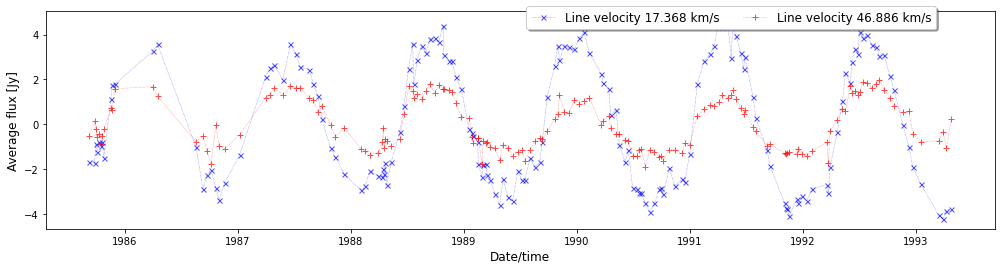

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle=':', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.7)
ax.plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle=':', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.7)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

### Compute the periodogram
Find the best period in days

In [78]:
import periodogram

#from periodogram import lomb_scargle
# we will upsample the signal for CSD calculations
dt = np.diff(ts_jd).min()

[blue_power,
 blue_frequency,
 blue_period,
 blue_time,
 blue_model] = periodogram.lomb_scargle(ts_jd.value,
                                        blue_timeseries,
                                        dt=dt.value)
blue_time = Time(np.array(blue_time), format=tsformat)

[red_power,
 red_frequency,
 red_period,
 red_time,
 red_model] = periodogram.lomb_scargle(ts_jd.value,
                                       red_timeseries,
                                       dt=dt.value)
red_time = Time(np.array(red_time), format=tsformat)

In [79]:
print(header)
period = (blue_period+red_period)/2.
print('Blue period = {:.2f} [days]'.format(blue_period))
print('Red period  = {:.2f} [days]'.format(red_period))
print('Avg period  = {:.2f} [days]'.format(period))

print((blue_period-red_period)/2.)

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD, 17.368, 46.886

Blue period = 472.58 [days]
Red period  = 472.58 [days]
Avg period  = 472.58 [days]
0.0


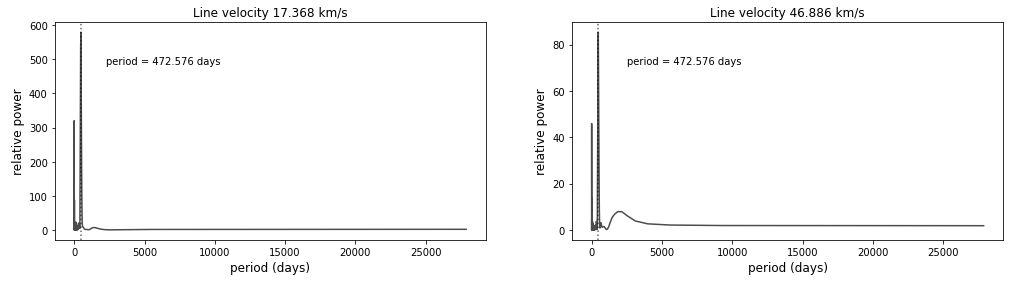

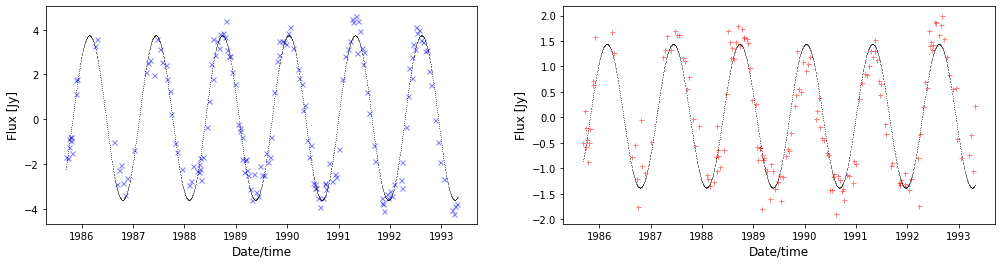

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 4),
                        facecolor='white')
period_range = 1./blue_frequency  # period is the inverse of frequency
axs[0].plot(period_range, blue_power, 'k', alpha=0.7)
axs[0].axvline(blue_period, color='k',linestyle=':', alpha=0.6)
axs[0].set_title('Line velocity {} km/s'.format(blue_velocity))
axs[0].set_xlabel('period (days)', fontsize=12)
axs[0].set_ylabel('relative power', fontsize=12)
axs[0].text(-0.05,0.83,
            'period = {:.3f} days'.format(blue_period),
            transform=ax.transAxes,
            color='k')

period_range = 1./red_frequency  # period is the inverse of frequency
axs[1].plot(period_range, red_power, 'k', alpha=0.7)
axs[1].axvline(red_period, color='k',linestyle=':', alpha=0.6)
axs[1].set_title('Line velocity {} km/s'.format(red_velocity))
axs[1].set_xlabel('period (days)', fontsize=12)
axs[1].set_ylabel('relative power', fontsize=12)
axs[1].text(0.5,0.83,
            'period = {:.3f} days'.format(red_period),
            transform=ax.transAxes,
            color='k')

fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 4),
                        facecolor='white')
axs[0].plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[0].plot(blue_time.datetime, blue_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_ylabel('Flux [Jy]', fontsize=12)

axs[1].plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=5,
        alpha=0.5)
axs[1].plot(red_time.datetime, red_model,
        color='k', marker=',', linestyle=':', linewidth=0.1, markersize=5,
        alpha=0.5)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_ylabel('Flux [Jy]', fontsize=12)

plt.show()

In [81]:
# width defines bar width
# percent defines current percentage
def progress(niter, width, percent):
    marks = math.floor(width * (percent / 100.0))
    spaces = math.floor(width - marks)

    loader = '[' + ('=' * int(marks)) + (' ' * int(spaces)) + ']'

    msg = "%d %s %d%% iterations used" % (niter, loader, percent)
    print(f'\r {msg}', end="", flush=True)

    if percent >= 100:
        print("\n")

Given the assumption of the OH masers on the near and far side of a spherical dust sphere, we would expect the period of the channels to be close to each other, assuming they are equal distance separated from the central start and experiencing the same pumping mechanism.

In [82]:
# relative phase shift between two signals from cross correlation
fs = 1./dt  # Sample frequency 1/d
freq = 1./period  # Frequency in 1/d

# fine tune period calculation
timestamps = ts_jd.value
light_curve = red_timeseries - red_timeseries.mean()

red_model_opt = stats.LombScargle(timestamps, red_timeseries).model(t=timestamps, frequency=freq)
smoothed_curve = red_model_opt - red_model_opt.mean()
residual = light_curve - smoothed_curve
rms = np.sqrt(np.mean(residual**2))
est = (1. - rms)*period
setp = 0.01#0.001
testp = np.arange(period-est, period+est, setp)
phase_fit = np.linspace(0., 1., len(ts_jd.value))
hndle = stats.LombScargle(timestamps, light_curve)
rms = []
print('enter here')
for cnt, p in enumerate(testp):
    progress(cnt+1, 50, (float(cnt+1)/float(len(testp)))*100)
    f = 1./p
    mag_fit =hndle.model(t=ts_jd.value, frequency=f)
    residual = light_curve - mag_fit
    rms.append(np.sqrt(np.mean(residual**2)))
# dummy print for progress
print('exit here')

err = np.abs(period-testp[np.argmin(rms)]) 
print('Uncertainty period pm {:.3f} [days]'.format(err))

enter here
 51758 [==================================================] 100% iterations used

exit here
Uncertainty period pm 0.736 [days]


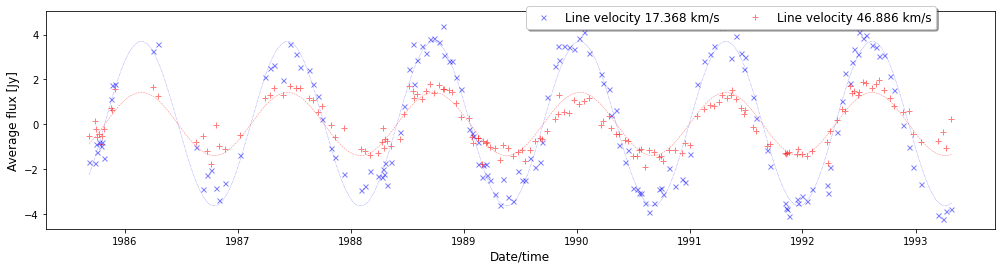

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model,
        color='b', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model,
        color='r', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

We see the period fit appropriately, also with the two smoothed signals there is not phase difference since the periodogram fit the period and phase -- the mean amplitude is returned for the smooth function and the increase in amplitude in the blue signal at the end of the monitoring period is not reflected in the smooth cureve as expected.

If you know the frequency, it is probably more accurate to fit a sine wave to each of the two vectors than to use the FFT. The problem with the FFT is that it fits harmonics of a wave whose period is equal to the length of the time series, and your signal may not lie at exactly one of those frequencies.

Relation between time delay ($\Delta T$) and phase lag ($\phi$): $2\pi \Delta T = \phi$

In [84]:
# get the models for the averaged period rather than the channel specific period
timestamps = ts_jd.value
diff = np.diff(ts_jd).min()
model_time = periodogram.upsample(timestamps[0], timestamps[-1], diff.value)

blue_model = stats.LombScargle(timestamps, blue_timeseries).model(t=model_time, frequency=freq)
blue_channel = blue_model-blue_model.mean()
red_model = stats.LombScargle(timestamps, red_timeseries).model(t=model_time, frequency=freq)
red_channel = red_model-red_model.mean()

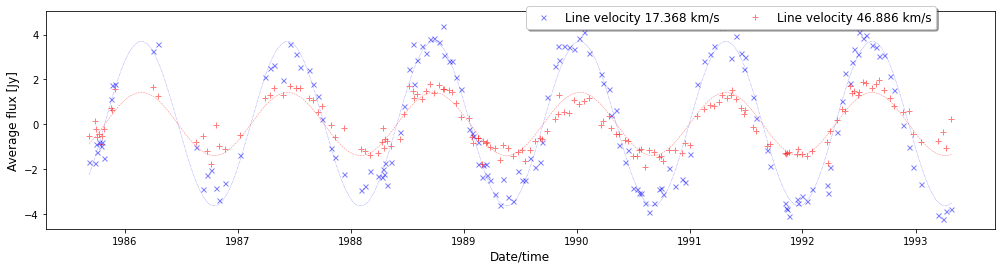

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_timeseries,
        color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(blue_velocity),
        alpha=0.5)
ax.plot(blue_time.datetime, blue_model,
        color='b', linestyle=':', linewidth=0.5, markersize=5,
        alpha=0.7)

ax.plot(jd_datetime, red_timeseries,
        color='r', marker='+', linestyle='none', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(red_velocity),
        alpha=0.5)
ax.plot(red_time.datetime, red_model,
        color='r', linestyle='--', linewidth=0.5, markersize=6,
        alpha=0.5)
ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper left',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)
plt.show()

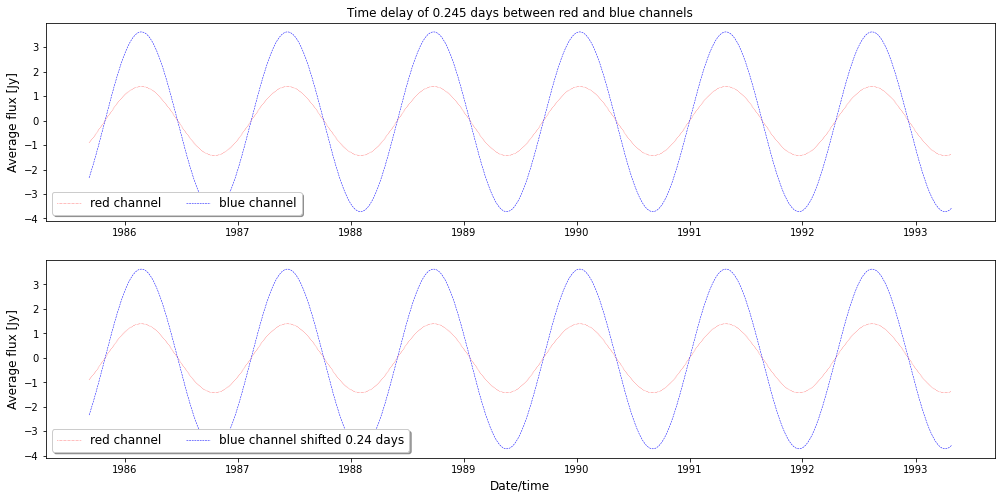

In [86]:
phase_offset_rad=np.arccos(np.dot(blue_channel, red_channel)/(np.linalg.norm(blue_channel)*np.linalg.norm(red_channel)))
time_delay = phase_offset_rad/(2.*np.pi*freq)

fig, axs = plt.subplots(nrows=2, ncols=1,
                        figsize=(17, 8),
                        facecolor='white')
axs[0].plot(red_time.datetime, red_model-red_model.mean(),
            color='r', linestyle=':', linewidth=0.5,
            label='red channel')
axs[0].plot(blue_time.datetime, blue_model-blue_model.mean(),
            color='b', linestyle='--', linewidth=0.5,
            label='blue channel')
axs[0].set_title('Time delay of {:.3f} days between red and blue channels'.format(time_delay))
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

axs[1].plot(red_time.datetime, red_model-red_model.mean(),
            color='r', linestyle=':', linewidth=0.5,
            label='red channel')
axs[1].plot(blue_time.datetime+timedelta(days=time_delay), blue_model-blue_model.mean(),
            color='b', linestyle='--', linewidth=0.5,
            label='blue channel shifted {:.2f} days'.format(time_delay))
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].legend(ncol=2,
          loc='lower left',
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)
plt.show()

In [87]:
def get_folded_phase(ts, period):
    """Fold the observation times with the best period of the variable signal."""
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (ts / period) % 1
    return phase

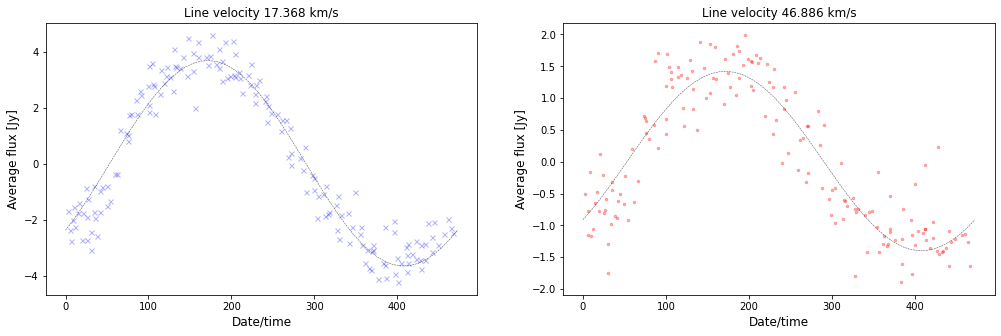

In [88]:
# compute model fitted values
phase_fit = np.linspace(0., 1.)
phase = get_folded_phase(ts_jd.value, period)

blue_mag_fit = stats.LombScargle(
                ts_jd.value, blue_timeseries - blue_timeseries.mean()).model(
                    t=phase_fit * period, frequency=1./period)

red_mag_fit = stats.LombScargle(
                ts_jd.value, red_timeseries - red_timeseries.mean()).model(
                    t=phase_fit * period, frequency=1./period)

# Plot folded lightcurve
fig, axs = plt.subplots(nrows=1, ncols=2,
                        figsize=(17, 5),
                        facecolor='white')
axs[0].plot(period*phase, blue_timeseries - blue_timeseries.mean(),
            color='b', marker='x', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[0].plot(period*phase_fit, blue_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[0].set_ylabel('Average flux [Jy]', fontsize=12)
axs[0].set_xlabel('Date/time', fontsize=12)
axs[0].set_title('Line velocity {} km/s'.format(blue_velocity))

axs[1].plot(period*phase, red_timeseries - red_timeseries.mean(),
            color='r', marker='.', linestyle='none', linewidth=0.5, markersize=5,
            alpha=0.3)
axs[1].plot(period*phase_fit, red_mag_fit,
            color='k', linestyle='--', linewidth=0.5, markersize=5,
            alpha=0.7)
axs[1].set_ylabel('Average flux [Jy]', fontsize=12)
axs[1].set_xlabel('Date/time', fontsize=12)
axs[1].set_title('Line velocity {} km/s'.format(red_velocity))

plt.show()